In [1]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


In [10]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from src.data_preprocessing import MultiSequencePipeline
from src.models import UCNNModel, ModelTrainer
from src.variables import INPUT_SHAPE, POOL_SIZE, NUM_OF_FEATURE_MAP, KERNEL_SIZE, DENSE_UNITS

In [24]:
TRAIN = False
data_dir = "../data/raw/"
model_name = '../src/ucnn_model.h5'


In [4]:
def read_data():
    dataframes = {}
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            path = os.path.join(data_dir, filename)
            df = pd.read_csv(path)
            identifier = filename.split('.')[0].split('_')[1]
            dataframes[identifier] = df
    return dataframes

In [25]:
# preprocess 
dfs = read_data()
multi_sequence_pipeline = MultiSequencePipeline(dfs, INPUT_SHAPE[0])
processed_data = multi_sequence_pipeline.process_all()

x_train, x_test, y_train, y_test = multi_sequence_pipeline.merge(processed_data)

/home/ashraf/PycharmProjects/stock-market-prediction/src/data_preprocessing.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data[col].fillna(method='ffill', inplace=True)
/home/ashraf/PycharmProjects/stock-market-prediction/src/data_preprocessing.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data[col].fillna(method='ffill', inplace=True)
/home/ashraf/PycharmProjects/stock-market-prediction/src/data_preprocessing.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data[col].fillna(method='ffill', inplace=True)
/home/ashraf/PycharmProjects/stock-market-prediction/src/data_preprocessing.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill(

In [26]:
x_train.shape, y_train.shape

((5460, 60, 82, 1), (5460,))

In [27]:
ucnn_model = UCNNModel()
ucnn_model.build_model(input_shape=INPUT_SHAPE, num_feature_maps=NUM_OF_FEATURE_MAP,
                       kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE, dense_units=DENSE_UNITS)

ucnn_model.compile_model()
trainer = ModelTrainer(model=ucnn_model.model, epochs=100, batch_size=32)

# Train the model
if TRAIN:
    history = trainer.train_model(x_train=x_train, y_train=y_train, validation_data=(x_test, y_test))
    ucnn_model.save_model(model_name)
else:
    ucnn_model.load_model(model_name)

Model loaded from ../src/ucnn_model.h5


In [8]:
ucnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 60, 82, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 1, 8)          664       
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 1, 8)          136       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 1, 8)          0         
 g2D)                                                 

In [12]:
y_pred = ucnn_model.predict(x_test)

36/36 [==============================] - 0s 3ms/step


In [13]:
y_pred_classes = (y_pred > 0.5).astype("int32")

36/36 [==============================] - 0s 2ms/step
Mean Squared Error: 0.29298737993189466
R^2 Score: -0.1834762320380947


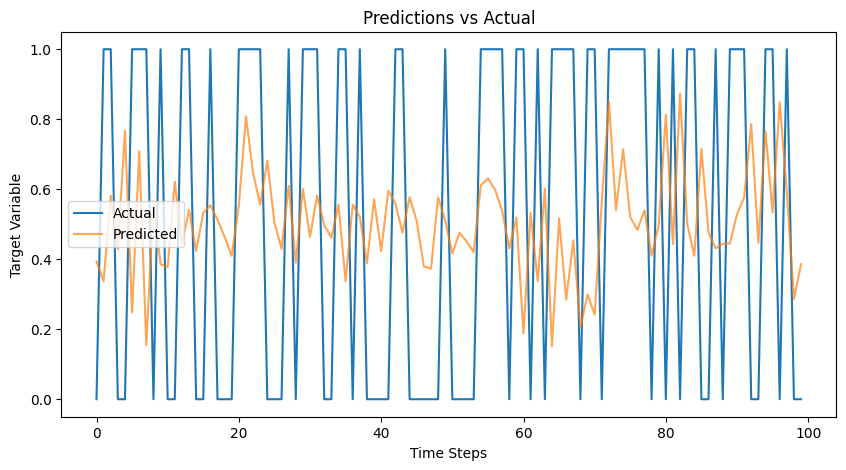

In [14]:
ucnn_model.evaluate(x_test, y_test)
n = 100
ucnn_model.plot_predictions(y_test[:n], y_pred[:n])

In [15]:
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5127
F1 Score: 0.5311
Precision: 0.5633
Recall: 0.5024


In [18]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

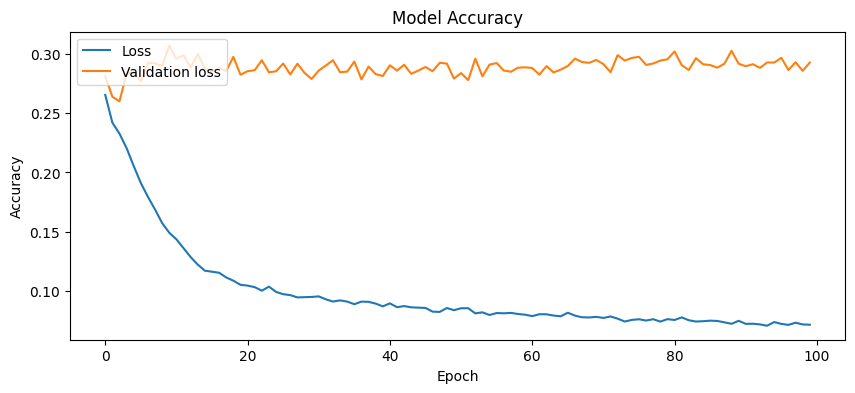

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss')  
plt.plot(history.history['val_loss'], label='Validation loss')  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
